In [285]:
import logging
import hashlib
import time

from epdlib import Layout, Update

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
logging.basicConfig(level=logging.INFO)
logging.debug('foobar')


DEBUG:root:foobar


In [99]:
logging.getLogger().setLevel('INFO')
logging.getLogger().setLevel('DEBUG')

In [5]:
def strict_enforce(*types):
    """strictly enforce type compliance within classes
    
    Usage:
        @strict_enforce(type1, type2, (type3, type4))
        def foo(val1, val2, val3):
            ...
    """
    def decorator(f):
        def new_f(self, *args, **kwds):
            #we need to convert args into something mutable   
            newargs = []        
            for (a, t) in zip(args, types):
                if not isinstance(a, t):
                    raise TypeError(f'"{a}" is not type {t}')
#                 newargs.append( t(a)) #feel free to have more elaborated convertion
            return f(self, *args, **kwds)
        return new_f
    return decorator

In [7]:
class A:
    '''dummy class for testing'''
    pass

In [452]:
class Plugin:
    def __init__(self, name=None, resolution=None, layout={}, 
                 update_function=None, max_priority=-1,
                 refresh_rate=60, min_display_time=30, config={},
                 **kwargs):
        self.name = name
        if resolution:
            self.resolution = resolution
        
        self.layout = layout
        
        if update_function:
            self._add_update_function(update_function)
        else:
            self.update_function = print('no update function set')
            
        self.max_priority = max_priority
        
        self.refresh_rate = refresh_rate
        self.min_display_time = min_display_time
        
        self.config = config
        
        self.last_ask = 0
        self.hash = self._generate_hash()
        self.data = {}
        self.image = None
        self.priority = -1
    
    @property
    def name(self):
        '''name of plugin
        name(`str`)'''
        return self._name
    
    @name.setter
    def name(self, name):
        self._name = str(name)
        
    @property
    def resolution(self):
        return self._resolution
        
    @resolution.setter
    @strict_enforce((list, tuple))
    def resolution(self, resolution):
        self._resolution = resolution    
    
    @property
    def layout(self):
        return self.layout_obj.layout
    
    @layout.setter
    @strict_enforce(dict)
    def layout(self, layout):
        self.layout_obj = Layout(resolution=self.resolution, layout=layout)
        

    
    def _add_update_function(self, function):
        self.update_function = function.__get__(self)
        
    def _generate_hash(self):
        my_hash = hashlib.sha1()
        my_hash.update(str(time.time()).encode('utf-8')+str(self.name).encode('utf-8'))
        return my_hash.hexdigest()[:10]        
    
    def _is_ready(self):
        if time.monotonic() - self.last_ask > self.refresh_rate:
            self.last_ask = time.monotonic()
            return True
        else:
            logging.debug(f'wait for {self.refresh_rate - (time.monotonic() - self.last_ask)} seconds')
            return False
        
    def update(self):
        if self._is_ready():
            is_updated, data, priority = self.update_function()
            if data != self.data:
                self.data = data
                self.layout_obj.update_contents(data)
                self.image = self.layout_obj.concat()
                self.hash = self._generate_hash()
                self.priority = priority
        else:
            pass
        
            
        return self.hash
    
    

In [453]:
clock_layout = {
    'digit_time': {
        'image': None,
        'max_lines': 3,
        'width': 1,
        'height': 1,
        'abs_coordinates': (0, 0),
        'rand': True,
        'font': '../fonts/Dosis/Dosis-VariableFontwght.ttf',
    },
}


test = A()
test.config = {'update_interval': 10}
test.max_priority = 1

from datetime import datetime
def clock_plugin(self):
    data = {'digit_time': datetime.now().strftime("%H:%M:%S")}
    priority = self.max_priority
    is_updated = True
    
    return (is_updated, data, priority) 

In [454]:
clock_plugin(test)

(True, {'digit_time': '22:29:04'}, 1)

In [455]:
slim_layout = {
    'title': {                       # text only block
        'image': None,               # do not expect an image
        'max_lines': 2,              # number of lines of text
        'width': 1,                  # 1/1 of the width - this stretches the entire width of the display
        'height': 2/3,               # 1/3 of the entire height
        'abs_coordinates': (0, 0),   # this block is the key block that all other blocks will be defined in terms of
        'hcenter': True,             # horizontally center text
        'vcenter': True,             # vertically center text 
        'relative': False,           # this block is not relative to any other. It has an ABSOLUTE position (0, 0)
        'font': '../fonts/Anton/Anton-Regular.ttf', # path to font file
        'font_size': None            # Calculate the font size because none was provided
    },

    'artist': {
        'image': None,
        'max_lines': 1,
        'width': 1,
        'height': 1/3,
        'abs_coordinates': [0, None],   # X = 0, Y will be calculated
        'hcenter': True,
        'vcenter': True,
        'font': '../fonts/Dosis/Dosis-VariableFontwght.ttf',
        'relative': ['artist', 'title'], # use the X postion from abs_coord from `artist` (this block: 0)
                                       # calculate the y position based on the size of `title` block
    }
}

slim_test = A()
slim_test = A()
slim_test.config = {'player_name': 'MacPlay', 'refresh_rate': 30}
slim_test.priority = -1
slim_test.max_priority = 0

import lmsquery
def slim_plugin(self):
    now_playing = None
    data = {
        'id': 0,
        'title': 'Err: No Player',
        'artist': 'Err: No Player',
        'coverid': 'Err: No Player',
        'duration': 0,
        'album_id': 'Err: No Player',
        'genre': 'Err: No Player',
        'album': 'Err: No Player',
        'artwork_url': 'Err: No Player',
        'mode': 'None'
    }

    is_updated = False
    priority = -1
    
    failure = (is_updated, data, priority)
    
    player_name = self.config['player_name']
    
    # check if LMS Query object is initiated
    if not hasattr(self, 'my_lms'):
        # add LMSQuery object to self
        logging.debug(f'building LMS Query object for player: {player_name}')
        self.my_lms = lmsquery.LMSQuery(player_name=player_name)
    try:
        # fetch the now playing data for the player
        now_playing = self.my_lms.now_playing()
        # remove the time key to make comparisions now_playing data updates easier in the Plugin class
        if 'time' in now_playing:
            now_playing.pop('time')
    except requests.exceptions.ConnectionError as e:
        logging.error(f'could not find player "{player_name}": {e}')
        return failure
    except KeyError as e:
        logging.warning(f'error getting now plyaing information for "{player_name}": KeyError {e}')
        return failure
    
    if now_playing:
        data = now_playing
    
    # set the priority based on play state
    if now_playing['mode'] == 'play':
        priority = self.max_priority
        is_updated = True
    elif now_playing['mode'] == 'pause':
        priority = self.max_priority + 1
        is_updated = True
    else:
        priority = -1
        is_updated = False
        
    return (is_updated, data, priority)
    

In [456]:
slim_plugin(slim_test)

DEBUG:root:building LMS Query object for player: MacPlay
DEBUG:root:searching for servers for 5 seconds
DEBUG:root:setting LMS Server to first found: 192.168.178.9
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 569
DEBUG:root:found player "MacPlay" on server: 192.168.178.9
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 316
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 369
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 247


(True,
 {'id': 11937,
  'title': 'The Remains of Rock & Roll',
  'artist': 'Broken Bells',
  'coverid': 'aa1f9276',
  'duration': 294.52,
  'album_id': '1480',
  'genre': 'Indie',
  'album': 'After the Disco',
  'artwork_url': 'http://192.168.178.9:9000/music/aa1f9276/cover.jpg',
  'mode': 'pause'},
 1)

In [460]:
config = {
    'main': {
        'resolution': (500, 400)
    },
    'Plugin: Clock': {
        'layout': clock_layout,
        'update_function': clock_plugin,
        'refresh_rate': 30,
        'min_display_time': 10,
        'max_priority': 1
    },
    'Plugin: LMS': {
        'layout': slim_layout,
        'update_function': slim_plugin,
        'refresh_rate': 5,
        'player_name': 'MacPlay',
        'min_display_time': 15,
        'max_priority': 0
    },
#     'Plugin: LibreSpot': {
#         'layout': layout,
#         'update_function': spot_plugin,
#         'update_rate': 10,
#         'port': 24879, 
#         'host': 'localhost',
#         'min_display_time': 20,
#         'player_name': 'SpoCon-Spotify'
#     }
}

plugins = {}

for section in config:
    if section.startswith('Plugin: '):
        my_config = config[section]
        my_config['name'] = section
        my_config['resolution'] = config['main']['resolution']
        my_config['config'] = config[section]
        my_plugin = Plugin(**my_config)
        my_dict = {'plugin': my_plugin,
                   'display_timer': Update(),
                   'hash': my_plugin.hash,
                   'min_display_time': my_plugin.min_display_time}
        
        plugins[section] = my_dict

DEBUG:root:creating layout
DEBUG:root:calculating layout for resolution (500, 400)
DEBUG:root:layout id(2942177168)
DEBUG:root:*****digit_time*****
DEBUG:root:checking layout keys
DEBUG:root:adding key: padding: 0
DEBUG:root:adding key: hcenter: False
DEBUG:root:adding key: vcenter: False
DEBUG:root:adding key: inverse: False
DEBUG:root:adding key: relative: False
DEBUG:root:adding key: font_size: None
DEBUG:root:adding key: maxchar: None
DEBUG:root:adding key: dimensions: None
DEBUG:root:adding key: scale_x: None
DEBUG:root:adding key: scale_y: None
DEBUG:root:dimensions: (500, 400)
DEBUG:root:section has absolute coordinates
DEBUG:root:coordinates: (0, 0)
DEBUG:root:calculating maximum font size for area: (500, 400)
DEBUG:root:using font: /home/pi/src/epd_display/fonts/Dosis/Dosis-VariableFontwght.ttf
DEBUG:root:target X font dimension 588.2352941176471
DEBUG:root:target Y font dimension 100.0
DEBUG:root:Y target reached
DEBUG:root:test string: W W W ; pixel dimensions for fontsize 

DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: True
INFO:root:updating blocks
DEBUG:root:updating block: digit_time
DEBUG:root:formatting string: 23:14:03
DEBUG:root:formatted list:
 ['23:14:03']
DEBUG:root:creating blank image area: (500, 400) with inverse: False
DEBUG:root:line size: 282, 100
DEBUG:root:max x dim so far: 282
DEBUG:root:dimensions of text portion of image: (282, 100)
DEBUG:root:drawing text at 0, 0
DEBUG:root:with dimensions: 282, 100
DEBUG:root:randomly positioning text within area
DEBUG:root:pasting text portion at coordinates: 48, 170
DEBUG:root:concating blocks into single image
DEBUG:root:pasitng **digit_time** image at: (0, 0)
DEBUG:root:screen_timer ran out -- checking for a refresh
DEBUG:root:hash changed, time for update
DEBUG:root:updating this screen


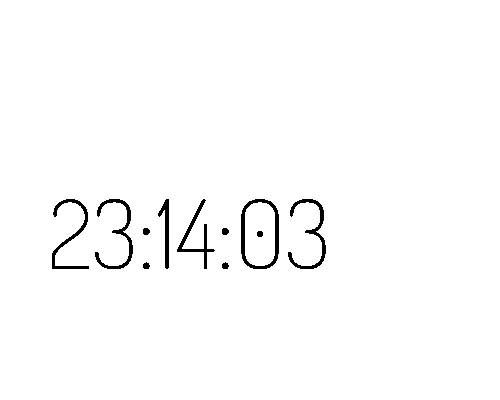

DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 322
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 393
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 275
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 28.834782365942374 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 3.8999953661113977 seconds
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 27.816255745012313 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 2.8814465230097994 seconds

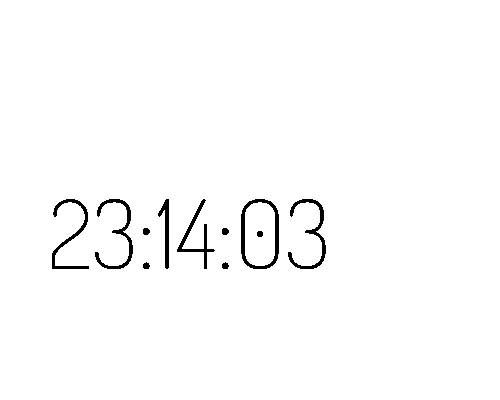

DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 321
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 390
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 274
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 18.440736524993554 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 3.8949182629585266 seconds
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 17.42144665296655 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 2.8757901669014245 seconds


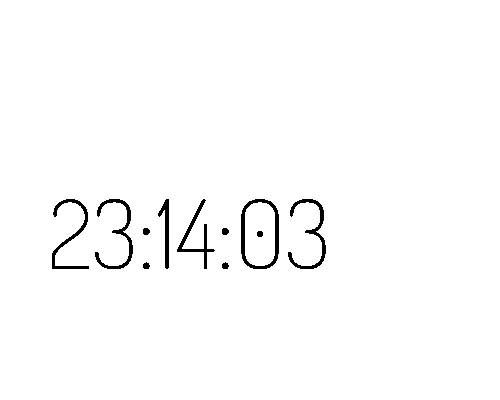

DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 318
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 390
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 276
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 8.0534581389511 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 3.900990165071562 seconds
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 7.033984731999226 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 2.881505350000225 seconds
DEBUG

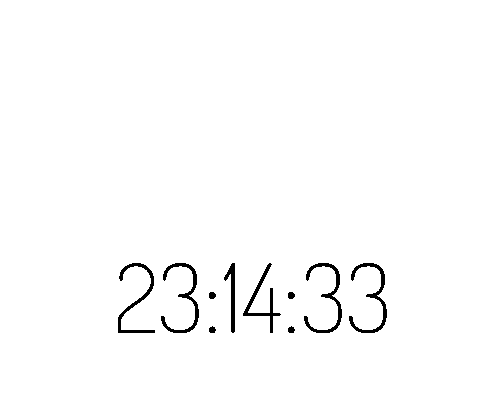

DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 318
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 388
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 274
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 27.76482030202169 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 3.8895666239550337 seconds
DEBUG:root:[[ Plugin: Clock ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 26.744040001998655 seconds
DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:root:wait for 2.871380309923552 seconds
D

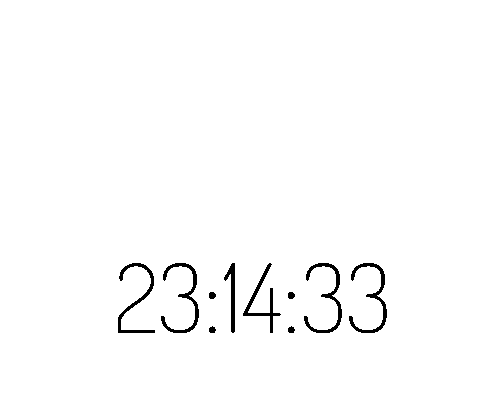

DEBUG:root:[[ Plugin: LMS ]]
DEBUG:root:can_update: False
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 317
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 391
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.178.9:9000
DEBUG:urllib3.connectionpool:http://192.168.178.9:9000 "POST /jsonrpc.js HTTP/1.1" 200 265
DEBUG:chardet.charsetprober:EUC-TW Taiwan prober hit error at byte 118
DEBUG:chardet.charsetprober:utf-8  confidence = 0.505
DEBUG:chardet.charsetprober:SHIFT_JIS Japanese confidence = 0.01
DEBUG:chardet.charsetprober:EUC-JP Japanese confidence = 0.01
DEBUG:chardet.charsetprober:GB2312 Chinese confidence = 0.01
DEBUG:chardet.charsetprober:EUC-KR Korean confidence = 0.01
DEBUG:chardet.charsetprober:CP949 Korean confidenc

KeyboardInterrupt: 

In [479]:
from IPython.display import display

screen_timer = Update()
my_min_display_time = 0
last_name = None
can_update = True

while True:

    for name, p in plugins.items():
        logging.debug(f'[[ {name} ]]')
        logging.debug(f'can_update: {can_update}')
        update_hash = p['plugin'].update()        
        
        if screen_timer.last_updated > my_min_display_time:
            logging.debug('screen_timer ran out -- checking for a refresh')
            if update_hash != p['hash']:
                logging.debug('hash changed, time for update')
                can_update = True
            else:
                can_update = False
        
        if can_update:            
                            
            logging.debug('updating this screen')
            
            # update the timer
            display(p['plugin'].image)
            screen_timer.update()
            my_min_display_time = p['min_display_time']
            last_name = name
            can_update = False

    time.sleep(1)